# Step by step graphs
I want to make a bunch of graphs that go step by step in showing how we make our synthetic signals.

In [7]:
from astropy.table import Table, Column
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G, sigma_sb, c
import scipy.stats

from thejoker.data import RVData
import astropy.units as u

import warnings
warnings.filterwarnings('ignore')

In [3]:
AllAvg_LMC = fits.open('AllAvg_LMC')
AllAvg_SMC = fits.open('AllAvg_SMC')
AllAvg_LMC = AllAvg_LMC[1].data
AllAvg_SMC = AllAvg_SMC[1].data
AllAvg_LMC = Table(AllAvg_LMC)
AllAvg_SMC = Table(AllAvg_SMC)

In [4]:
%run Table_Convert.py
AllAvg_SMC=Table_Convert(AllAvg_SMC)
AllAvg_LMC=Table_Convert(AllAvg_LMC)

In [11]:
%run Binary_Data_Clean2.py
Tables = Binary_Data_Clean2('/home/cody/Binary Search/2nd_Data_Set/mc_rgb_nocuts.fits','/home/cody/Binary Search/2nd_Data_Set/allVisit-t9-l31c-58247.mc.fits',
                          '/home/cody/Binary Search/parsec_decamsdss_all.fits.gz')
AllAvg_LMC = Tables.nvisits_cut(AllAvg_LMC,5)
AllAvg_SMC = Tables.nvisits_cut(AllAvg_SMC,5)

In [12]:
%run Binary_Fraction.py
thing_LMC = Binary_Fraction(AllAvg_LMC)
thing_SMC = Binary_Fraction(AllAvg_SMC)

Text(0.5,1,'2M05085554-7249522')

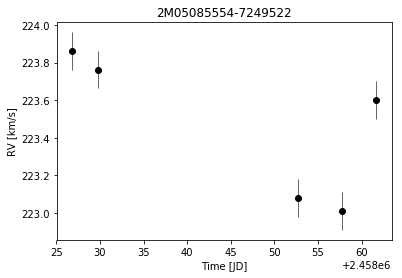

In [13]:

>>> t = thing_LMC.AAS_TABLE['RADIAL_DATE'][0] * u.d
>>> rv = thing_LMC.AAS_TABLE['RADIALV'][0] * u.km/u.s
>>> err = thing_LMC.AAS_TABLE['RADIAL_ERR'][0] * u.km/u.s
>>> data = RVData(t=t, rv=rv, stddev=err)
>>> ax = data.plot() 

>>> ax.set_xlabel("Time [JD]") 
>>> ax.set_ylabel("RV [km/s]")
ax.set_title(thing_LMC.AAS_TABLE['APOGEE_ID'][0])

In [14]:
 def fake_solo_detection(self,N, m_min, jitter, reduce):
        jitter = 2 * 0.015 ** (1 / 3 * self.AAS_TABLE["LOGG"][N])
        #Make some fake solo RV measurments
        solo_RV = []
        for n in self.AAS_TABLE['RADIAL_ERR'][N]:
            rv_foo = np.random.normal(self.AAS_TABLE['VHELIO_AVG'][N], n,)
            solo_RV.append(rv_foo)

        #Keep the real ovserved error
        solo_err = np.sqrt(self.AAS_TABLE['RADIAL_ERR'][N]**2 + jitter**2)
        #Don't think I need the date, but my old stuff has it so I'm keeping it
        Date = self.AAS_TABLE['RADIAL_DATE'][N]
        #Finds the chi_squared and p-value
        solo_chi_squared = self.chi_sq_mean(solo_RV, solo_err, reduce)
        p_value = 1 - chi2.cdf(solo_chi_squared, len(solo_RV) - 1)
        #Check if it's a binary or not.
        if p_value < 0.05:
            solo_binary = True
        else:
            solo_binary = False
        return p_value, solo_binary

In [15]:
solo_RV = []
for n in thing_LMC.AAS_TABLE['RADIAL_ERR'][0]:
    rv_foo = np.random.normal(thing_LMC.AAS_TABLE['VHELIO_AVG'][0], n,)
    solo_RV.append(rv_foo)

0.7273977


Text(0.5,1,'Synthetic Solor Star using 2M05085554-7249522')

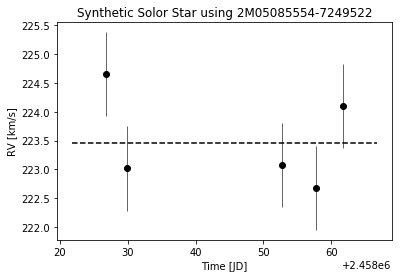

In [16]:
np.random.seed(1)
solo_RV = []

jitter = 2 * 0.015 ** (1 / 3 * thing_LMC.AAS_TABLE["LOGG"][0])
print(thing_LMC.AAS_TABLE["LOGG"][0])
err = np.sqrt(thing_LMC.AAS_TABLE['RADIAL_ERR'][0]**2 + jitter**2) * u.km/u.s
for n in err.value:
    rv_foo = np.random.normal(thing_LMC.AAS_TABLE['VHELIO_AVG'][0], n,)
    solo_RV.append(rv_foo)
t = thing_LMC.AAS_TABLE['RADIAL_DATE'][0] * u.d
rv = solo_RV * u.km/u.s
data = RVData(t=t, rv=rv, stddev=err)
ax = data.plot() 

ax.set_xlabel("Time [JD]") 
ax.set_ylabel("RV [km/s]")
ax.hlines(thing_LMC.AAS_TABLE['VHELIO_AVG'][0], t[0].value-5, t[-1].value+5, linestyle =  'dashed')
ax.set_title('Synthetic Solor Star using {}'.format(thing_LMC.AAS_TABLE['APOGEE_ID'][0]))

[<Quantity 1304.45547846 jupiterMass>, <Quantity 0.42879965>, <Quantity 8704.0646349 d>, <Quantity 11.27639209 AU>, <Quantity 2.17499564 rad>, <Quantity 2.75325772 rad>, <Quantity 2.81048972 rad>, <Quantity 68502.53137058 km / s>, '2M05085554-7249522'] 1.2797845602035522


<Quantity 1.24522568 solMass>

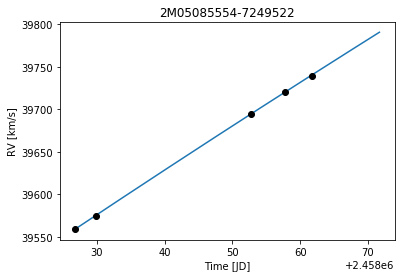

In [17]:
# This is some stuff that cy_rv_from_elements needs for it's time input. Not sure why but it doens't
# work without these few lines. i.e. DO NOT TOUCH!
rv, err, buddy_list = thing_LMC.fake_rv_binary(0, 200, 'L', True)
Date = np.linspace(t[0].value, t[-1].value+10, 1000)
buddy_list
t_buddy = Time(Date, format = 'mjd')

t_buddy = t_buddy.tcb.mjd

procb = ArrayProcessor(t_buddy)

t_buddy, = procb.prepare_arrays()

td0 = t_buddy[0]

td0 = Time(td0, format = 'mjd')

# Makes the observed radial velocity in the binaries Barrycenter.
rv_buddy = cy_rv_from_elements(t_buddy, buddy_list[2].to(u.day).value, 1. , buddy_list[1].value, buddy_list[5].value,
                               buddy_list[6].value, td0.tcb.mjd,
                               anomaly_tol = 1E-10, anomaly_maxiter = 128)

# Then we move the velocity to be in our reference frame. This is the exact analytical radial velcity of a star
# with the given paramiters.
rv_buddy = (buddy_list[7] * rv_buddy + thing_LMC.AAS_TABLE['VHELIO_AVG'][0] * u.km/ u.s)


#  def fake_rv_binary(self, N, m_min, period, jitter):

t = thing_LMC.AAS_TABLE['RADIAL_DATE'][0] * u.d

data = RVData(t=t, rv=rv, stddev=err)
ax = data.plot() 

ax.set_xlabel("Time [JD]") 
ax.set_ylabel("RV [km/s]")
ax.set_title(thing_LMC.AAS_TABLE['APOGEE_ID'][0])
ax.plot(Date, rv_buddy,)
print(buddy_list, thing_LMC.AAS_TABLE['ISO_MEANM'][0])
buddy_list[0].to(u.solMass)

In [ ]:
%run Binary_Fraction.py
thing_LMC = Binary_Fraction(AllAvg_LMC)
thing_SMC = Binary_Fraction(AllAvg_SMC)
#real_data = [real_data_detection_LMC_5, binary_bool_LMC_5, LMC_binary_detection_5, rd_err_LMC]
#real_data_LMC = thing_LMC.Real_Data_Fraction()
#real_data_SMC = thing_SMC.Real_Data_Fraction()

#synthetic_rates = [p_value_result_LMC, binary_result_LMC,  detection_rate_LMC, errors_LMC]
synthetic_rates_LMC = thing_LMC.synthetic_detection_rate(30,'L',True,False,[0,1],30)
#synthetic_rates_LMC = thing_LMC.synthetic_detection_rate(200,'L',True,False,[0,1],30)
synthetic_rates_LMC2 = thing_LMC.synthetic_detection_rate(500,'L',True,False,[0,1],30)

synthetic_rates_LMC3 = thing_LMC.synthetic_detection_rate(30,'U',True,False,[0,1],30)
#synthetic_rates_LMC = thing_LMC.synthetic_detection_rate(200,'U',True,False,[0,1],30)
synthetic_rates_LMC4 = thing_LMC.synthetic_detection_rate(500,'U',True,False,[0,1],30)

In [ ]:
plt.figure(figsize = (6,6))
b_frac = [0,1]
plt.plot(b_frac, synthetic_rates_LMC[2],'.-', color = 'C0', label = '$m_{min} = 30 M_{J}$, P = ln normal')
plt.plot(b_frac, synthetic_rates_LMC2[2],'.-', color = 'C1', label = '$m_{min} = 500 M_{J}$, P = ln normal')
         
plt.plot(b_frac, synthetic_rates_LMC3[2],'.--', color = 'C0', label = '$m_{min} = 30 M_{J}$, P = Uniform')
plt.plot(b_frac, synthetic_rates_LMC4[2],'.--', color = 'C1', label = '$m_{min} = 500 M_{J}$, P = Uniform')         

plt.plot(b_frac, synthetic_rates_LMC5[2],'.--', color = 'C2', label = 'Mess around with i')  
plt.plot(b_frac, synthetic_rates_LMC6[2],'.--', color = 'C3', label = 'Mess around with e')  

plt.annotate('{:0f}'.format(synthetic_rates_LMC[2][1]),xy=(b_frac[1]+0.01,synthetic_rates_LMC[2][1]))
plt.annotate('{:0f}'.format(synthetic_rates_LMC2[2][1]),xy=(b_frac[1]+0.01,synthetic_rates_LMC2[2][1]-0.01))
plt.annotate('{:0f}'.format(synthetic_rates_LMC3[2][1]),xy=(b_frac[1],synthetic_rates_LMC3[2][1] - 0.03))
plt.annotate('{:0f}'.format(synthetic_rates_LMC5[2][1]),xy=(b_frac[1]+0.02,synthetic_rates_LMC5[2][1]))

plt.plot([0,1],[0,1],'--', color = 'black',label = 'Perfect Detection')
plt.xlabel('Binary Fraction', size = 18)
plt.ylabel('Detection Rate', size = 18)
plt.xlim(-0.05,1.2)
plt.title('Paramiter distribution for LMC', size = 18)
plt.legend()
plt.show()

In [ ]:
%run Binary_Fraction.py #Changed i range to be around pi/2 changing it back after running this
thing_LMC = Binary_Fraction(AllAvg_LMC)
synthetic_rates_LMC5 = thing_LMC.synthetic_detection_rate(500,'L',True,False,[0,1],10)

In [ ]:
%run Binary_Fraction.py #Changed e to be 0.2 - 0.93
thing_LMC = Binary_Fraction(AllAvg_LMC)
synthetic_rates_LMC6 = thing_LMC.synthetic_detection_rate(500,'L',True,False,[0,1],10)

In [ ]:
epoch_span_LMC = [n[-1] - n[0] for n in AllAvg_LMC['RADIAL_DATE']]
epoch_span_SMC = [n[-1] - n[0] for n in AllAvg_SMC['RADIAL_DATE']]

In [ ]:
plt.hist([epoch_span_LMC,epoch_span_SMC], label = ['LMC', 'SMC'])
plt.xlabel('Epoch Span (days)')
plt.legend()